## Расшифровка VIN-кодов автомобилей

*ФИО: Смоляк П.В.*

*Telegram: @Smolchonok*

#### Описание проекта 

 - Разоборать структуру VIN-кода, для прогнозирования цены автомобиля.

#### Цель проекта

- Сделать прогноз цен на автомобили FORD на информации ции скрытой в VIN-хкода

#### Задачи

- изучить структуру VIN-кода, какие информационные компоненты он содержит (регион, производитель, характеристики автомобиля и т. д.).
- составить регулярные выражения для поиска и извлечения конкретных частей VIN-кода, таких как производитель, модель и год выпуска.
- найти ошибки в VIN-кодах с помощью регулярных выражений
- распарсить текстовый документ с VIN-кодами и ценами
- построить модель предсказания цены по VIN-коду

#### Содержание:

1. [Загрузка данных](#1)
2. [Информация для создания паттерна VIN-кода](#2)
3. [Северо-Американский формат VIN](#3)
4. [Создание набора данных](#4)
5. [Подготовка данных для обучения](#5)
6. [LinearRegression](#6)
7. [RandomForestRegressor](#7)
8. [CatBoost](#8)
9. [Подведём итоги](#9)


##### Полезные ссылки

- https://en.wikibooks.org/wiki/Vehicle_Identification_Numbers_(VIN_codes)#Table_of_Contents
- https://en.wikibooks.org/wiki/Vehicle_Identification_Numbers_(VIN_codes)/World_Manufacturer_Identifier_(WMI)
- https://en.wikibooks.org/wiki/Vehicle_Identification_Numbers_(VIN_codes)/Printable_version#Model#
- https://en.wikipedia.org/wiki/List_of_Ford_factories


In [68]:
import re 
import pandas as pd
import phik
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [69]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

In [4]:
RANDOM_STATE = 42
CV=4

In [5]:
SCORING=['neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']

### Загрузка данных:  <a id='1'></a>

In [6]:
with open('vin_ford_train.txt', encoding='UTF-8', mode='r') as f:
    vin_text = f.read()

In [7]:
print(vin_text[:200])

[2FMDK3JC4BBA41556:12500]мой[3FA6P0H75ER208976:14500]дядя [3FAHP08Z17R268380:1300][1FMCU0GX3DUC59421:15200]самых [1FAHP2E89DG119368:11600] верных[1FM5K8D82DGA16143:26400][1FTFW1CFXCFC23663:14000][2FMD


Данные загружены, в них имеются перечисление кодов и цен, данные нуждаются в очистке и подробном анализе, для получения необходимой информации, чтобы в дальнейшем провести прогнозирование цен.

### Информация для создания паттерна VIN-кода   <a id='2'></a>

Для начала давайте ближе познакомимся со структурой VIN-кодов, на картинке ниже представленная подробная информация об американских, европейских и австралийских VIN-кодах:

**Форматы VIN**

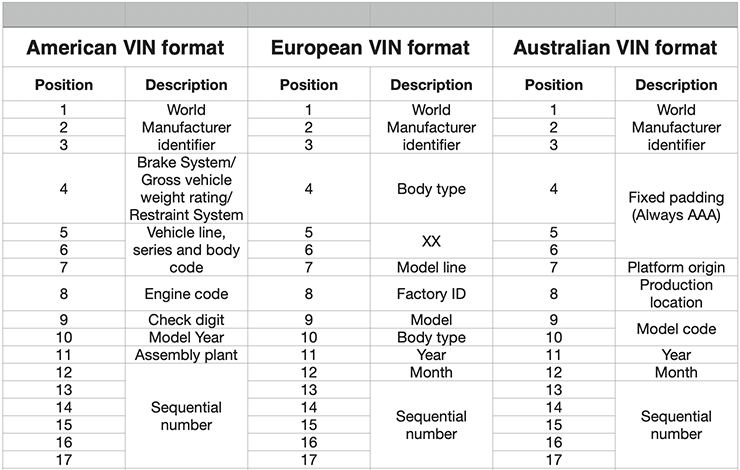

#### Расшифровка VIN-кода автомобилей Ford:

In [8]:
ford_wmi = {
    'AFA': 'Ford Motor Company of Southern Africa & Samcor',
    'AFB': 'Mazda BT-50 made by Ford Motor Company of Southern Africa',
    'JC0': 'Ford brand cars made by Mazda',
    'JC2': 'Ford Courier made by Mazda',
    'KNJ': 'Ford Festiva & Aspire made by Kia',
    'LJX': 'JMC Ford',
    'LVS': 'Changan Ford & Changan Ford Mazda',
    'MAJ': 'Ford India',
    'MNB': 'Ford Thailand',
    'NM0': 'Ford Otosan',
    'PE1': 'Ford Motor Company Philippines',
    'PE3': 'Mazda Philippines made by Ford Motor Company Philippines',
    'PR8': 'Ford',
    'LFA': 'Ford Lio Ho Motor Co Ltd. old designation',
    'RHA': 'Ford Lio Ho Motor Co Ltd. new designation',
    'RL0': 'Ford Vietnam',
    'SBC': 'Iveco Ford Truck',
    'SFA': 'Ford UK',
    'VSK': 'Nissan Motor Iberica SA, Nissan passenger car/MPV/van/SUV/pickup & Ford Maverick 1993–1999',
    'VS6': 'Ford Spain',
    'WF0': 'Ford Germany',
    'X9F': 'Ford Motor Company ZAO',
    'Z6F': 'Ford Sollers (Russia)',
    '1FA': 'Ford car',
    '1FB': 'Ford "bus" (van with more than 3 rows of seats)',
    '1FC': 'Ford stripped chassis made by Ford',
    '1FD': 'Ford incomplete vehicle',
    '1FM': 'Ford MPV/SUV',
    '1FT': 'Ford truck',
    '1F1': 'Ford SUV - Limousine (through 2009)',
    '1F6': 'Ford stripped chassis made by Detroit Chassis LLC',
    '1ZV': 'Ford made by AutoAlliance International',
    '2FA': 'Ford car',
    '2FM': 'Ford MPV/SUV',
    '2FT': 'Ford truck',
    '3FA': 'Ford car',
    '3FC': 'Ford stripped chassis made by Ford & IMMSA',
    '3FE': 'Ford Mexico',
    '3FM': 'Ford MPV/SUV',
    '3FN': 'Ford F-650/F-750 made by Blue Diamond Truck Co. (truck)',
    '3FR': 'Ford F-650/F-750 made by Blue Diamond Truck Co. (incomplete vehicle)',
    '3FT': 'Ford truck',
    '4F2': 'Mazda SUV made by Ford',
    '4F4': 'Mazda truck made by Ford',
    '4N2': 'Nissan Quest made by Ford',
    '5LD': 'Ford & Lincoln incomplete vehicle – limousine (2010–2014)',
    '6F1': 'Ford',
    '6FP': 'Ford Australia',
    '7A5': 'Ford New Zealand',
    '8AF': 'Ford Argentina',
    '9BF': 'Ford Brazil',
}

#### Разрешенные символы в VIN-кодах

In [9]:
allowed = r'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'
allowed

'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'

Краткие выводы:
- Номер состоит как из букв, так и из цифр их 17.
-  Символами VIN могут быть заглавные буквы от A до Z и цифры от 1 до 0; однако буквы I, O и Q никогда не используются во избежание ошибок при чтении.
-  В VIN не допускается использование знаков или пробелов.
-  Нет двух одинаковых VIN.

### Северо-Американский формат VIN   <a id='3'></a>

Создадим шаблон для наших данных и получим всю необходимую информацию в виде DataFrame:

In [10]:
wmi = f'(?P<wmi>[{allowed}]{{3}})'          # 1-3
brake = f'(?P<brake>[{allowed}])'           # 4
model = f'(?P<model>[{allowed}]{{3}})'      # 5-7
engine = f'(?P<engine>[{allowed}])'         # 8
check = f'(?P<check>[{allowed}])'           # 9
year = f'(?P<year>[{allowed}])'             # 10
plant = f'(?P<plant>[{allowed}])'           # 11
vis = f'(?P<vis>[{allowed}]{{3}}\\d{{3}})'  # 12-17
price = f'(?P<price>\d+)'                   # цена


pattern = f'\\b{wmi}{brake}{model}{engine}{check}{year}{plant}{vis}:{price}\\b'
print(pattern)

\b(?P<wmi>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3})(?P<brake>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<model>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3})(?P<engine>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<check>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<year>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<plant>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<vis>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3}\d{3}):(?P<price>\d+)\b


### Создание набора данных    <a id='4'></a>

Применим ко всем текстовым данным:

In [11]:
vin_df = pd.DataFrame([x.groupdict() for x in re.compile(pattern).finditer(vin_text)])
vin_df.head()

,wmi,brake,model,engine,check,year,plant,vis,price
0,2FM,D,K3J,C,4,B,B,A41556,12500
1,3FA,6,P0H,7,5,E,R,208976,14500
2,3FA,H,P08,Z,1,7,R,268380,1300
3,1FM,C,U0G,X,3,D,U,C59421,15200
4,1FA,H,P2E,8,9,D,G,119368,11600


Получим общую информацию:

In [12]:
vin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   wmi     71884 non-null  object
 1   brake   71884 non-null  object
 2   model   71884 non-null  object
 3   engine  71884 non-null  object
 4   check   71884 non-null  object
 5   year    71884 non-null  object
 6   plant   71884 non-null  object
 7   vis     71884 non-null  object
 8   price   71884 non-null  object
dtypes: object(9)
memory usage: 4.9+ MB


***Выводы:***

В данных отсутствуют пропуски, необходимо:
- привести цены к правильному типу
- проверить все ли коды относятся к автомобилям Ford

#### Проверка: относятся ли wmi-коды к автомобилям Ford

In [13]:
for row in vin_df['wmi'].values:
    count = 0
    if row in ford_wmi.keys():
        continue
    else:
        print('wmi-код не принадлежат автомобилям марки FORD', row)
        count +=1
print(f'Проверка завершена: количество несоответствий {count}')

Проверка завершена: количество несоответствий 0


Таких wmi-кодов нет, данные в порядке.

#### Приведём цены к нужному числовиму типу:

In [14]:
vin_df['price'] = vin_df['price'].astype(int)

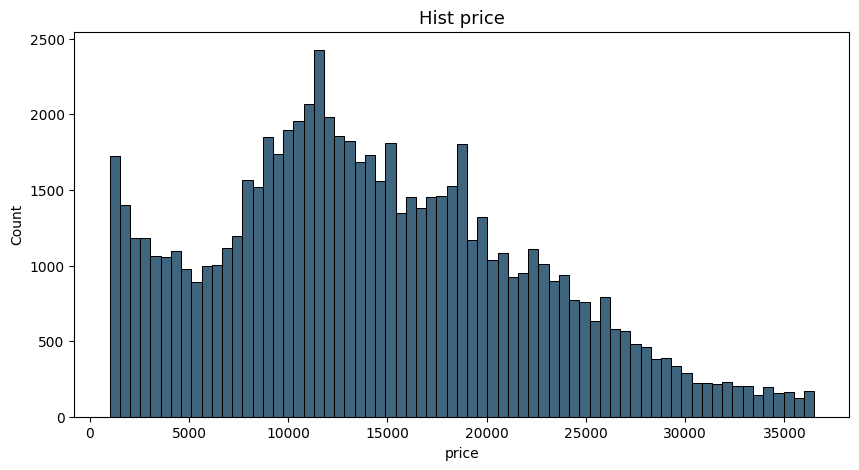

In [15]:
plt.figure(figsize=(10, 5))
plt.title('Hist price', fontsize=13)
sns.histplot(vin_df['price'], color='#003153');

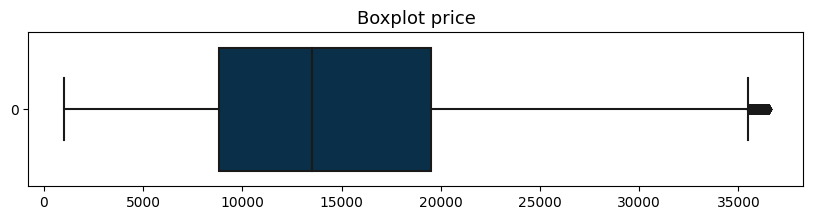

In [16]:
plt.figure(figsize=(10, 2))
plt.title('Boxplot price', fontsize=13)
sns.boxplot(vin_df['price'], color='#003153', orient='h');

In [17]:
pd.DataFrame(vin_df['price'].describe()).T

,count,mean,std,min,25%,50%,75%,max
price,71884.0,14321.449377,7827.057238,1000.0,8800.0,13500.0,19500.0,36500.0


In [18]:
vin_df['price'].value_counts(normalize=True, bins=5)*100

price
(8100.0, 15200.0]     35.622670
(15200.0, 22300.0]    24.979133
(964.499, 8100.0]     22.507095
(22300.0, 29400.0]    13.025152
(29400.0, 36500.0]     3.865951
Name: proportion, dtype: float64

***Выводы:***

Цены предполагаю, что исчисляются в долларах. Минимальное значение в стоимости составляет 1 тыс.. Значительных выбросов нет, на графике боксплота есть небольшое количество значений, которые выходят за пределы усов, но так как мы точно не знаю дополнительную информацию, данные значения убирать не будем. 
Основная концентрация цен находится примерно в диапазоне 8-20 тыс. Максимальное значение составляет 36,5 тыс. Средняя цена находится близко к медианной цене, что подтверждает об отсутствии значительных выбросов в данных. График гистограммы похож на нормальное распределение, но имеет пика в районе нуля.

Посмотрим на корреляцию признаков, отсортирую по убыванию влияния признаков на таргет

In [19]:
vin_df.head()

,wmi,brake,model,engine,check,year,plant,vis,price
0,2FM,D,K3J,C,4,B,B,A41556,12500
1,3FA,6,P0H,7,5,E,R,208976,14500
2,3FA,H,P08,Z,1,7,R,268380,1300
3,1FM,C,U0G,X,3,D,U,C59421,15200
4,1FA,H,P2E,8,9,D,G,119368,11600


In [20]:
print('Количество дубликатов: ', vin_df.duplicated().sum())

Количество дубликатов:  0


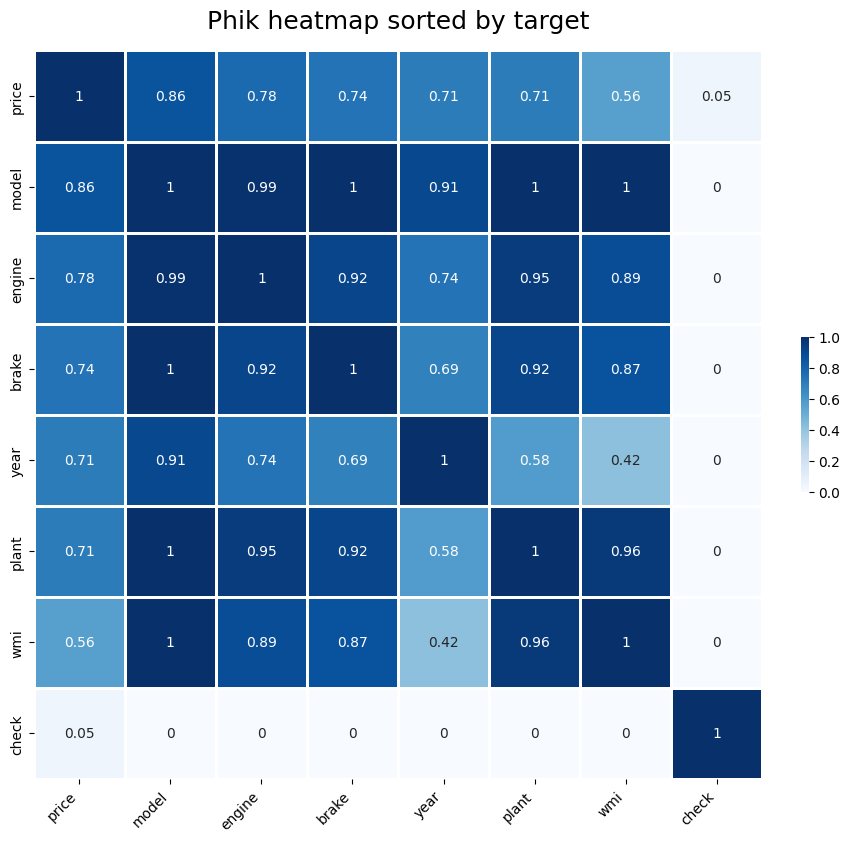

In [21]:
plt.figure(figsize=(10, 10))

sotred_columns = (
    vin_df.loc[:, vin_df.columns != 'vis'].phik_matrix(interval_cols=vin_df.columns!= 'vis')
    .round(2)
    .sort_values("price", ascending=False, axis=1)
    .columns
)

heatmap = sns.heatmap(
    vin_df.loc[:, vin_df.columns != 'vis'].phik_matrix(interval_cols=vin_df.columns!= 'vis')
    .round(2)
    .sort_values("price", ascending=False, axis=1)
    .reindex(sotred_columns),
    annot=True,
    square=True,
    cmap="Blues",
    vmax=1,
    vmin=0,
    cbar_kws={"fraction": 0.01},  # shrink colour bar
    linewidth=2,
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
)
heatmap.set_title("Phik heatmap sorted by target", fontdict={"fontsize": 18}, pad=16)
plt.show()

#### ***Обший вывод:***

- мы провели создание формата VIN по имеющейся информации
- создали набор данных для работы
- преобразовали тип price на int
- проверили все ли wmi-коды относятся к марке Ford-автомобилей
- выбросов в ценах нет, основная концентрация цен находится примерно в диапазоне 8-20 тыс.
- на цену большое влияние оказывают признаки model, engine, brake, year, plant, wmi.
- показатель chek имеет слабую корреляцию с ценой, и не коррелирует с другими показателями.
- также наблюдается большая корреляция признаков между собой, что в дальнейшем возможно потребует дополнительного рассмотрения.


### Подготовка данных для обучения  <a id='5'></a>

In [25]:
X = vin_df.drop('price', axis=1)
y = vin_df['price']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

Убедимся в том, что выборки поделились правильно:

In [27]:
print('Размер обучающей выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер обучающей выборки: (57507, 8)
Размер тестовой выборки: (14377, 8)


Создадим для удобства новый список с именами колонок с категориальными признаками:

In [28]:
category = [col for col in vin_df.columns if col != 'price']

In [29]:
encode_ordinal = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan, dtype='float')
scaler = MinMaxScaler()

In [30]:
X_train_ordinal = pd.DataFrame(encode_ordinal.fit_transform(X_train), columns=category, index=X_train.index)
X_test_ordinal = pd.DataFrame(encode_ordinal.transform(X_test), columns=category, index=X_test.index)

X_train_scaler = pd.DataFrame(scaler.fit_transform(X_train_ordinal), columns=category, index=X_train_ordinal.index)
X_test_scaler = pd.DataFrame(scaler.transform(X_test_ordinal), columns=category, index=X_test_ordinal.index)

print('Размер обучающего набора для моделей : ',  X_train_scaler.shape)
print('Размер тестового набора  для моделей : ',  X_test_scaler.shape)

Размер обучающего набора для моделей :  (57507, 8)
Размер тестового набора  для моделей :  (14377, 8)


Данные были разделены на обучающие и тестовые, произведено кодирование и масштабирование с помощью MinMaxScaler, так как это более оптимальное масштабирование для нашего таргета.

### LinearRegression <a id='6'></a>

In [264]:
params_liner = {'fit_intercept': [True, False],
          'copy_X': [True, False],
          'positive': [True, False]}

In [265]:
model_linear = LinearRegression()

grid_linear = GridSearchCV(model_linear,  params_liner, cv=CV, n_jobs=-1, scoring=SCORING, refit='neg_mean_squared_error')

grid_linear.fit(X_train_scaler, y_train)


print('test_neg_mean_squared_error: ', -grid_linear.cv_results_['mean_test_neg_mean_squared_error'].mean())
print('test_neg_mean_absolute_error: ',  -grid_linear.cv_results_['mean_test_neg_mean_absolute_error'].mean())
print('test_neg_mean_absolute_percentage_error: ', -grid_linear.cv_results_['mean_test_neg_mean_absolute_percentage_error'].mean())

print('Лучшие параметры: '+ str(grid_linear.best_params_))

test_neg_mean_squared_error:  34188701.41211021
test_neg_mean_absolute_error:  4263.064717218664
test_neg_mean_absolute_percentage_error:  0.6306080671556709
Лучшие параметры: {'copy_X': True, 'fit_intercept': True, 'positive': False}


### RandomForestRegressor <a id='7'></a>

In [66]:
params_forest = {'max_depth': [3,5,None],
            'n_estimators': [10,100],
            'bootstrap': [True, False],
            'random_state': [RANDOM_STATE]}

In [67]:
model_forest = RandomForestRegressor()

grid_forest = GridSearchCV(model_forest, params_forest, cv=CV, scoring=SCORING, refit='neg_mean_squared_error')

grid_forest.fit(X_train_scaler, y_train)


print('test_neg_mean_squared_error: ', -grid_forest.cv_results_['mean_test_neg_mean_squared_error'].mean())
print('test_neg_mean_absolute_error: ',  -grid_forest.cv_results_['mean_test_neg_mean_absolute_error'].mean())
print('test_neg_mean_absolute_percentage_error: ', -grid_forest.cv_results_['mean_test_neg_mean_absolute_percentage_error'].mean())

print('Лучшие параметры: '+ str(grid_forest.best_params_))

test_neg_mean_squared_error:  16910558.10782426
test_neg_mean_absolute_error:  2918.108338907701
test_neg_mean_absolute_percentage_error:  0.3384927096151695
Лучшие параметры: {'bootstrap': True, 'max_depth': None, 'n_estimators': 100, 'random_state': 42}


### CatBoost <a id='8'></a>

In [63]:
# задам параметры модели
model_catboost = CatBoostRegressor(random_state=RANDOM_STATE, cat_features=category,
    loss_function='RMSE', verbose=False)

train_pool = Pool(X_train_scaler, y_train)
# выбираю сетку гиперпараметров модели
param_grid_catboost = {'learning_rate': [0.1],
                       'iterations': [1000],
                       'early_stopping_rounds': [30]}


In [55]:
# соберем все вместе
model_catboost_result = model_catboost.grid_search(param_grid_catboost, train_pool,  
                                                   y_train,  cv=4,   plot=False,
                                                   refit=True,  search_by_train_test_split=True, 
                                                   verbose=False)

Stopped by overfitting detector  (30 iterations wait)

bestTest = 2784.126949
bestIteration = 757

Training on fold [0/4]

bestTest = 2773.158199
bestIteration = 675

Training on fold [1/4]

bestTest = 2781.217095
bestIteration = 791

Training on fold [2/4]

bestTest = 2838.521196
bestIteration = 859

Training on fold [3/4]

bestTest = 2784.188556
bestIteration = 573



In [56]:
print('Лучшие результаты:', model_catboost_result['params'])
print('Root Mean Squared Error:',  min(model_catboost_result['cv_results']['test-RMSE-mean']))

Лучшие результаты: {'od_wait': 30, 'iterations': 1000, 'learning_rate': 0.1}
Root Mean Squared Error: 2794.603661498388


#### Тестирование лучшей модели

In [256]:
def get_regression_metrics(model_regressor, X_test, y_test):
    # сохраняем предсказания и лучшие гиперпараметры
    preds_test = model_regressor.predict(X_test)
    best_params = model_regressor.get_params()

    # вычисляем метрики
    regression_metrics = pd.DataFrame(
        data={
            'Mean Absolute Error': [mean_absolute_error(y_test, preds_test)],
            'Mean Squared Error': [mean_squared_error(y_test, preds_test)],
            'Root Mean Squared Error': [np.sqrt(mean_squared_error(y_test, preds_test))],
            'Mean Absolute Percentage Error': [mean_absolute_percentage_error(y_test, preds_test)]
        },
        index=['test']
    )

    display(regression_metrics)

In [233]:
get_regression_metrics(model_catboost, X_test, y_test)

,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,Mean Absolute Percentage Error
test,1982.593905,7.835149e+06,2799.133619,0.208274


In [270]:
def importance_model(model):
    if model.feature_importances_:
        feature_df = pd.DataFrame({'feature_importance': model.feature_importances_, 
              'feature_names': X_test_scaler.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False).sort_values(by=['feature_importance'], ascending=True)
                                          
    feature_df.plot.barh(x='feature_names', y='feature_importance')
    plt.title('Важность признаков')
    plt.show()

In [ ]:
importance_model(model_catboost)

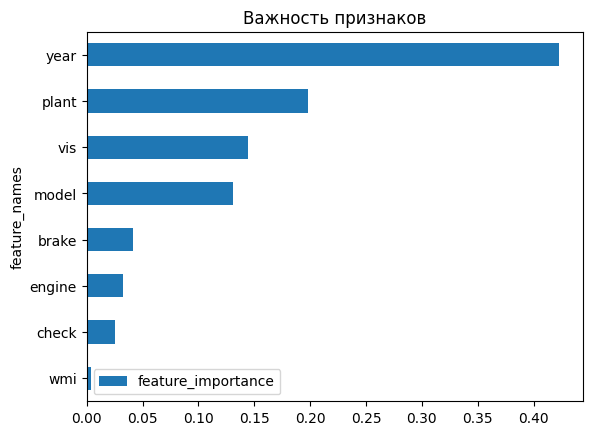

In [211]:
feature_df = pd.DataFrame({'feature_importance': model.feature_importances_, 
              'feature_names': X_test_scaler.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False).sort_values(by=['feature_importance'], ascending=True)
feature_df.plot.barh(x='feature_names', y='feature_importance')
plt.title('Важность признаков')
plt.show()

Наибольшее влияние на прогнозирование цен такие как: год, производитель, кузов и модель автомобиля.

### Подведём итоги <a id='9'></a>

У нас в распоряжении был текстовый файл  с VIN-кодами автомобилей Ford. Мы провели ознакомление с составом кода, загрузили данные, создали паттерн, на основе которого произвели очистку и извлечение необходимой информации для дальнейшей работы.

После создания набора данных, произведен был анализ показателей:
- проверили проверку на правильность wmi-кодов марке Ford
- привели столбец с таргетом(price) к целочисленному типу
- построили графики по целевому показателю

  Минимальное значение в стоимости составляет 1 тыс.. Значительных выбросов нет, на графике боксплота есть небольшое количество значений, которые выходят за пределы усов. Основная концентрация цен находится примерно в диапазоне 8-20 тыс. Максимальное значение составляет 36,5 тыс. Средняя цена находится близко к медианной цене, что подтверждает об отсутствии значительных выбросов в данных.

  Далее данные были разделены на обучающую и тестовую выборки и для дальнейшей работы были закодированы и масштабированны.

  В ходе работы были выбраны три модели для сравнения качества лучшей метрики RMSE:
- LinearRegression  + GridSearch
- RandomForestRegressor  + GridSearch
- CatBoost Regressor + GridSearch

  Лучшей моделью оказалась модель CatBoost на основании наименьшей метрики MSE, для которой потом было проведено тестирование. Показатели получились следующие:

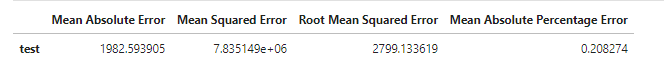

Наибольшее влияние в признаках оказывают: 
Для прогнозирования стоимости автомобилей по VIN-кодам мы рекомендуем использовать модель CatBoost, которая в процессе проделанной работы показала наилучший результат.